In [4]:
import sys; sys.path.insert(0, '..') #Add upper folder to path
from src.preprocess import Preprocess
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import yaml

In [11]:
with open("../src/analysis-config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

features_cols = config['features']
cat_features_cols = config['cat_features']
max_runtime = 300000
algorithms = config['algorithms']
runtime_cols = [algorithm + ' Runtime' for algorithm in algorithms]
runtime_cols.append('Y Runtime')
success_cols = [algorithm + ' Success' for algorithm in algorithms]
# data_path = '../src/AllData-labelled-with-features.csv'
data_path = '../data/from-vpn/experiments/30.11.20-linux-withlazycbs_cbsh-c/LAZYCBS/Lazy_EPEA_ICTS_SAT-with-features.csv'

df = pd.read_csv(data_path)

# drop_maps = None
# drop_maps = ['warehouse']

if drop_maps is not None:
    for maptype in drop_maps:
        df = df[~df.GridName.str.contains(maptype)]
    df = df.reset_index(drop=True)

In [8]:
preprocess = Preprocess(max_runtime, runtime_cols, features_cols, cat_features_cols, success_cols)

df, features_cols = preprocess.load_labelled_results(data_path, 
#                                                      drop_maps=['warehouse', 'maze-128-128-1'],
                                                     unsolved_only=False)

KeyError: 'Y'

In [60]:
success_cols

['astar Success',
 'macbs Success',
 'cbs Success',
 'icts Success',
 'epea Success',
 'cbsh Success']

### How many problems solved by only one solver? ###

In [73]:
df['SolvesFinishedCount'] = df[success_cols].sum(axis=1)

c:\users\omri\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [74]:
print("{n} of the problems solved by only one solver!".format(n=len(df[df['SolvesFinishedCount']==1])/len(df)))

0.14501987836023275 of the problems solved by only one solver!


In [75]:
df = df[df['SolvesFinishedCount']<len(success_cols)]
df = df.reset_index()

In [76]:
# df[(df['cbsh Success']==0)&(df['cbsh-c Success']==1)][['NumOfAgents','GridName','InstanceId']]

### What is the maximum number of agents solved for each map? ###

Note: A map is a combination of an instance and the grid.

In [77]:
max_agents_for_each_map_row_idxs = df.groupby(['GridName','InstanceId'])['NumOfAgents'].idxmax()

In [78]:
len(df)

19836

In [129]:
winners_df = df.iloc[max_agents_for_each_map_row_idxs.values][['NumOfAgents','Y','GridName','InstanceId']+success_cols]
winners_df.sort_values(['NumOfAgents'], ascending=False).head(20)

,NumOfAgents,Y,GridName,InstanceId,astar Success,macbs Success,cbs Success,icts Success,epea Success,cbsh Success
577,200,cbsh Runtime,Berlin_1_256,2,0,0,0,0,0,1
19616,198,epea Runtime,empty-48-48,7,0,0,0,0,1,0
3715,195,cbsh Runtime,Berlin_1_256,16,0,0,0,0,0,1
8101,195,cbsh Runtime,Paris_1_256,25,0,0,0,0,0,1
5904,187,cbsh Runtime,Paris_1_256,20,0,0,0,0,0,1
1265,186,cbsh Runtime,Berlin_1_256,3,0,0,0,0,0,1
6834,186,cbsh Runtime,Paris_1_256,22,0,0,0,0,0,1
19679,182,epea Runtime,Berlin_1_256,10,0,0,0,0,1,0
11464,174,cbsh Runtime,Berlin_1_256,11,0,0,0,0,0,1
19436,173,icts Runtime,Berlin_1_256,23,0,0,0,1,0,0


### How many maps each solver solved alone? (i.e. gain in coverage) ###

In [80]:
df[df['SolvesFinishedCount']==1]['Y'].value_counts()

cbsh Runtime     3886
epea Runtime      952
icts Runtime      537
astar Runtime      65
cbs Runtime        47
macbs Runtime      21
Name: Y, dtype: int64

Let's try to find patterns regarding the large amount of maps sat solved alone

### For each solver, how distributed are his "single solver" maps? ###

In other words - we want to check if there is a solver that wins by a large margin on a specific map (and therefore gains coverage).

In [81]:
df[(df['SolvesFinishedCount']==1)&(df.Y=='sat Runtime')].GridName.value_counts()

Series([], Name: GridName, dtype: int64)

### We can see that orz900d is highly dominated by sat. What will happen when we train the solver without it? ###
Although surprising, it didn't had impact on the results.


In [82]:
df[(df['SolvesFinishedCount']==1)&(df.Y=='sat Runtime')&(df.GridName=='orz900d')].InstanceId.value_counts()

Series([], Name: InstanceId, dtype: int64)

### Which maps have the highest std in terms of "single solvers" across different configurations? ###

In [83]:
s = df[(df['SolvesFinishedCount']==1)].groupby(['GridName'])['Y'].value_counts()
s.std(level='GridName').sort_values(ascending=False)

GridName
Paris_1_256            195.296356
orz900d                189.504617
Berlin_1_256           175.069510
lt_gallowstemplar_n    168.291414
brc202d                164.755880
random-32-32-20        160.513239
empty-48-48            158.272971
den312d                135.500308
Boston_0_256           120.378570
lak303d                109.601551
empty-16-16            106.522298
ht_chantry             105.310652
random-64-64-10         76.367532
ht_mansion_n            68.844632
w_woundedcoast          65.010256
ost003d                 60.648578
empty-32-32             52.044852
random-64-64-20         46.956540
room-64-64-16           46.378875
random-32-32-10         34.355980
room-32-32-4            32.046841
den520d                 30.934070
maze-32-32-2            22.627417
maze-32-32-4            17.097758
maze-128-128-2           7.505553
room-64-64-8             4.242641
empty-8-8                     NaN
Name: Y, dtype: float64

### Interesting! We see that sat exceed in specific configurations of orz only, but when it does - it does so in an outstanding way and wins by a large margin over the others. 

1. What's so special about those specific configurations of orz?
2. How can we use that knowledge during the training of the AS model? Maybe it emposes a bias?

### What is the margin for each map between the largest number of agents solved and the 2nd best solver? ###

In [84]:
max_num_of_agents_for_two_solvers_per_map = df[df['SolvesFinishedCount']>=2].groupby(['GridName','InstanceId'])['NumOfAgents'].max()


In [85]:
max_num_of_agents_for_single_solver_per_map = df[df['SolvesFinishedCount']==1].groupby(['GridName','InstanceId'])['NumOfAgents'].max()

In [86]:
margin_from_single_solver = max_num_of_agents_for_single_solver_per_map - max_num_of_agents_for_two_solvers_per_map
margin_from_single_solver.sort_values(ascending=False).head(10)

GridName      InstanceId
Berlin_1_256  16            123.0
              7              86.0
Paris_1_256   3              81.0
Berlin_1_256  3              77.0
empty-48-48   2              69.0
Paris_1_256   25             68.0
              21             46.0
              14             45.0
              16             45.0
orz900d       16             44.0
Name: NumOfAgents, dtype: float64

### Let's try to cluster the data given the features and try to see if those outliers (orz900d of instances 4,20,10) seems "strange" ###

In [87]:
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupShuffleSplit

groups = df['InstanceId']  # len of scenarios
gkf = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for index, (tr_ind, test_ind) in enumerate(gkf.split(df, df['Y'], groups)):
    X_train, X_test, y_train, y_test = df.iloc[tr_ind].copy(), df.iloc[test_ind].copy(), \
                                           df['Y'].iloc[tr_ind].copy(), df['Y'].iloc[test_ind].copy()
    
    features_cols_without_b_factor = features_cols.copy()
#     features_cols_without_b_factor.remove('BranchingFactor')
    print(features_cols_without_b_factor)
    kmeans = KMeans(n_clusters=len(success_cols)).fit(X_train[features_cols_without_b_factor])


['NumOfAgents', 'ObstacleDensity', 'GridName_Berlin_1_256', 'GridName_Boston_0_256', 'GridName_Paris_1_256', 'GridName_brc202d', 'GridName_den312d', 'GridName_den520d', 'GridName_empty-16-16', 'GridName_empty-32-32', 'GridName_empty-48-48', 'GridName_empty-8-8', 'GridName_ht_chantry', 'GridName_ht_mansion_n', 'GridName_lak303d', 'GridName_lt_gallowstemplar_n', 'GridName_maze-128-128-2', 'GridName_maze-32-32-2', 'GridName_maze-32-32-4', 'GridName_orz900d', 'GridName_ost003d', 'GridName_random-32-32-10', 'GridName_random-32-32-20', 'GridName_random-64-64-10', 'GridName_random-64-64-20', 'GridName_room-32-32-4', 'GridName_room-64-64-16', 'GridName_room-64-64-8', 'GridName_w_woundedcoast']


### Finding "Breaking points"
Points on instances where adding a single agent caused a dramatic increase in runtime

In [93]:
jump = 1
breaks = df[(df['Y Runtime'].shift(-jump)>df['Y Runtime']*5)&(df['Y Runtime']>5)].index.to_list()
after_breaks = [b+jump for b in breaks]
breaks.extend(after_breaks)


In [94]:
breaks.sort()
len(breaks)/2

449.0

In [97]:
df.iloc[breaks][['NumOfAgents','Y Runtime','Y','InstanceId','GridName']+features_cols].head(10)

,NumOfAgents,Y Runtime,Y,InstanceId,GridName,NumOfAgents,ObstacleDensity,GridName_Berlin_1_256,GridName_Boston_0_256,GridName_Paris_1_256,...,GridName_orz900d,GridName_ost003d,GridName_random-32-32-10,GridName_random-32-32-20,GridName_random-64-64-10,GridName_random-64-64-20,GridName_room-32-32-4,GridName_room-64-64-16,GridName_room-64-64-8,GridName_w_woundedcoast
153,18,168.6092,cbs Runtime,1,den312d,18,0.535613,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,19,1119.3184,cbsh Runtime,1,den312d,19,0.535613,0,0,0,...,0,0,0,0,0,0,0,0,0,0
158,23,2278.5247,cbsh Runtime,1,den312d,23,0.535613,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159,24,19578.2585,cbsh Runtime,1,den312d,24,0.535613,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219,37,113.1851,icts Runtime,1,empty-16-16,37,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
220,38,4750.6050,epea Runtime,1,empty-16-16,38,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
222,20,316.2874,cbsh Runtime,1,empty-8-8,20,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
223,21,3503.0762,cbsh Runtime,1,empty-8-8,21,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260,23,1861.1259,cbsh Runtime,1,lak303d,23,0.607185,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,24,38646.7190,cbsh Runtime,1,lak303d,24,0.607185,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Visualize some breaking points - the map before and after the addition of the "breaking" agent ###

### Plotting specific maps runtime distribution ###

In [120]:
def plot_problem_runtime_hist(df, instance_id,gridname,runtime_cols):
    fig,ax = plt.subplots()
    tmp_df = df[(df.InstanceId==instance_id)&(df.GridName==gridname)]
    for algorithm in runtime_cols:
        if algorithm=='Y Runtime':
            continue
#             plt.plot(tmp_df[algorithm].values,  '1-', label=algorithm)
        plt.plot(tmp_df[algorithm].values, label=algorithm)
        ax.set_xlabel("NumOfAgents")
        ax.set_ylabel("algorithm")
        ax.legend(loc='best')
        ax.set_title('Instance: {i},d grid: {g}'.format(i=instance_id,g=gridname))

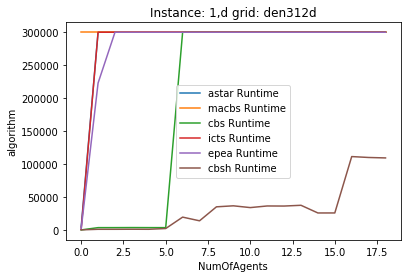

In [123]:
instance_id=1
gridname='den312d'
plot_problem_runtime_hist(df,instance_id,gridname,runtime_cols)

### How can we visualize the variability for each grid, across different instances? ###

In [130]:
winners_df['SolvesFinishedCount'] = winners_df[success_cols].sum(axis=1)

In [142]:
algorithm_success_in_map = winners_df[winners_df.SolvesFinishedCount==1].groupby('GridName')['Y'].value_counts()

In [165]:
winners_df[winners_df.GridName=='den520d']['Y']

211       cbsh Runtime
12835     icts Runtime
13012     epea Runtime
18836     epea Runtime
13262     epea Runtime
13525     icts Runtime
13672     icts Runtime
19635     epea Runtime
13989     icts Runtime
14115     epea Runtime
16592    astar Runtime
14340     epea Runtime
14532     epea Runtime
18909     epea Runtime
18990     epea Runtime
3882      cbsh Runtime
4346      cbsh Runtime
19108     icts Runtime
18474     icts Runtime
19200     epea Runtime
6367      cbsh Runtime
6928      cbsh Runtime
17820     icts Runtime
15993     epea Runtime
19527     epea Runtime
Name: Y, dtype: object

In [162]:
algorithm_success_in_map.groupby(['GridName']).mean()

GridName
Berlin_1_256            5.333333
Boston_0_256            4.333333
Paris_1_256             3.750000
brc202d                12.000000
den312d                 7.000000
den520d                 2.750000
empty-16-16             6.333333
empty-32-32             3.750000
empty-48-48             4.666667
empty-8-8              24.000000
ht_chantry              7.000000
ht_mansion_n            4.500000
lak303d                11.000000
lt_gallowstemplar_n    11.500000
maze-128-128-2          3.666667
maze-32-32-2            8.000000
maze-32-32-4            4.333333
orz900d                10.000000
ost003d                 5.500000
random-32-32-10         4.250000
random-32-32-20        11.500000
random-64-64-10         8.000000
random-64-64-20         4.000000
room-32-32-4            6.000000
room-64-64-16           4.000000
room-64-64-8            4.500000
w_woundedcoast          5.666667
Name: Y, dtype: float64